In [2]:
# install
!pip install findspark
!pip install pyspark
import findspark
findspark.init()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840629 sha256=b2d23a12a4025be64409879254cc6ca1a52eb8a0738bf31b9a71d96c936d0485
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [3]:
# init
import findspark
findspark.init()

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Start Spark session
spark = SparkSession.builder.appName("Amazon Fine Food Reviews Classification").getOrCreate()

# Load dataset
df = spark.read.csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv', header=True, inferSchema=True)

# Drop rows with missing values
df = df.dropna()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/21 12:47:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Create a new label column: convert rating to binary classification (positive or negative)
df = df.withColumn("label", (df.Score > 3).cast("integer"))  # Label as 1 for positive and 0 for negative

df = df.filter(df['label'].isNotNull())
df = df.filter((df['label'] == 0) | (df['label'] == 1))


In [5]:
# Split the data into train and test sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=1234)
# The Score column (which contains ratings from 1 to 5) is converted into a binary label:

# 1 for scores greater than 3 (positive reviews)
# 0 for scores less than or equal to 3 (negative reviews)

# Tokenize the reviews
tokenizer = Tokenizer(inputCol="Text", outputCol="words")

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")

# Convert words to term frequency
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)

# Apply IDF (inverse document frequency)
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Initialize RandomForest classifier
rf = RandomForestClassifier(featuresCol="scaledFeatures", labelCol="label", numTrees=50)

# Build pipeline
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, scaler, rf])

# Fit the model on the training data
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")



24/10/21 12:50:39 WARN MemoryStore: Not enough space to cache rdd_55_0 in memory! (computed 10.5 MiB so far)
24/10/21 12:50:39 WARN BlockManager: Persisting block rdd_55_0 to disk instead.
24/10/21 12:50:39 WARN MemoryStore: Not enough space to cache rdd_55_3 in memory! (computed 55.2 MiB so far)
24/10/21 12:50:39 WARN BlockManager: Persisting block rdd_55_3 to disk instead.
24/10/21 12:50:39 WARN MemoryStore: Not enough space to cache rdd_55_1 in memory! (computed 16.1 MiB so far)
24/10/21 12:50:39 WARN BlockManager: Persisting block rdd_55_1 to disk instead.
24/10/21 12:50:40 WARN MemoryStore: Not enough space to cache rdd_55_2 in memory! (computed 84.6 MiB so far)
24/10/21 12:50:40 WARN BlockManager: Persisting block rdd_55_2 to disk instead.
24/10/21 12:51:57 WARN MemoryStore: Not enough space to cache rdd_55_3 in memory! (computed 130.0 MiB so far)
24/10/21 12:52:01 WARN MemoryStore: Not enough space to cache rdd_55_0 in memory! (computed 195.3 MiB so far)
24/10/21 12:52:02 WARN M

Test Accuracy: 0.7781556099241294


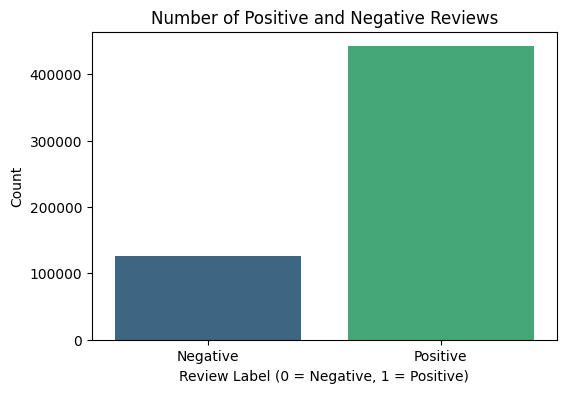

In [6]:
# Convert the Spark DataFrame to a Pandas DataFrame for easier plotting
df_pandas = df.select('label').toPandas()

# Count the number of positive and negative reviews
review_counts = df_pandas['label'].value_counts()

# Plot the data
plt.figure(figsize=(6,4))
sns.barplot(x=review_counts.index, y=review_counts.values, palette="viridis")
plt.title('Number of Positive and Negative Reviews')
plt.xlabel('Review Label (0 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

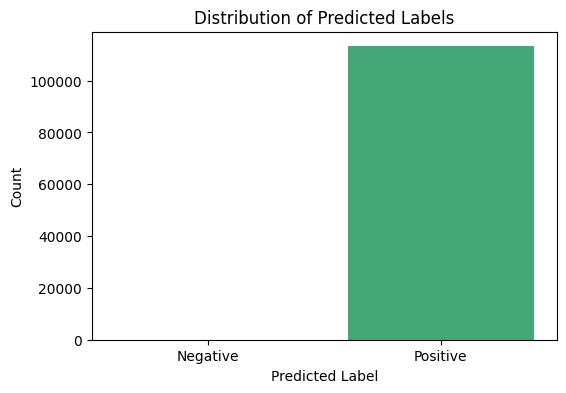

In [9]:
# Plot distribution of predicted labels
pred_label_dist = predictions.groupBy('prediction').count().toPandas()

# Plot the distribution of predictions
plt.figure(figsize=(6,4))
sns.barplot(x='prediction', y='count', data=pred_label_dist, palette="viridis")
plt.title('Distribution of Predicted Labels')
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()


Area Under ROC Curve: 0.78


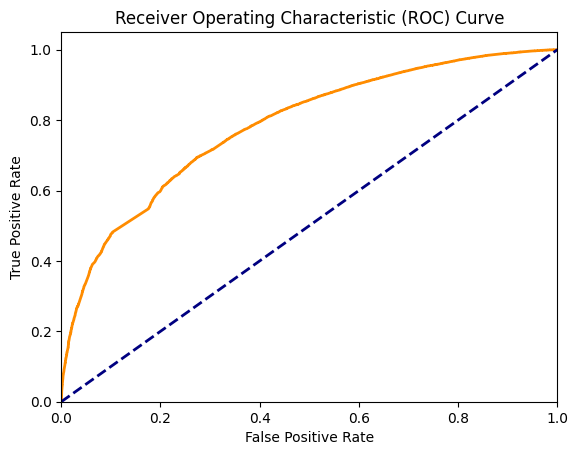

In [8]:
from sklearn.metrics import roc_curve  # Import roc_curve function

# Evaluate AUC
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)
print(f"Area Under ROC Curve: {roc_auc:.2f}")

# Convert predictions to Pandas
preds_labels = predictions.select('rawPrediction', 'label').collect()
y_true = [int(row['label']) for row in preds_labels]
y_scores = [float(row['rawPrediction'][1]) for row in preds_labels]

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()
